# Lab 5: Adversarial Examples and Special Topics

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

## Advanced optimizers
SGD with momentum is a fairly good optimizer, but assumes that every parameter it's updating should have the same learning rate (and that the learning rate should stay the same over time).
But, if a parameter contributes to a unit that activates often, it will more frequently receive strong gradient updates, and so have a higher "effective learning rate".
Having parameters with very different "effective learning rates" slows down learning, since either units which infrequently activate will have very low effective learning rates and be slow to converge, or units which frequently activate will have too-high effective learning rates and will not converge.

Several advanced "adaptive" optimizers have been developed to deal with this problem.
They have the additional advantage of working well with a broader range of learning rates than SGD, so they take less tuning.
They're particularly effective when you expect certain features to be rare or sparse, since this is when differences in effective learning rate appear.

I'll only describe the basics of these algorithms here.
If you're interested in reading more, check out [this post on ruder.io](http://ruder.io/optimizing-gradient-descent/index.html).
The [Keras documentation on optimizers](https://keras.io/optimizers/) also has some good info.

### Adagrad
Adagrad is an adaptive variant of SGD that divides the learning rate applied to a given parameter by the square root of the running total of gradient updates that parameter has _ever_ seen.
As training progresses, the learning rate of each parameter monotonically decreases as it experiences more gradient updates, and the parameters that are updated the most see the sharpest decrease.

Adagrad has the very appealing property that you basically don't need to tune the learning rate; the Keras documentation recommends leaving it fixed at 0.01.
But this robustness comes with a major downside: the "running total of past gradients" it keeps track of per-parameter strictly grows, so eventually the learning rate becomes very small.

This makes Adagrad a bad choice for long-running training tasks.
Qualitatively, I don't see Adagrad used very often.

To use Adagrad in TensorFlow, use [`tf.optimizers.Adagrad`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad).

### RMSProp and Adadelta
Instead of reducing the learning rate for a parameter based on all of the updates it's ever gotten, RMSprop and Adadelta use an exponential moving average of previous gradients, so the reduction is based on only the previous few updates. 
This prevents Adagrad's problem of monotonically-decreasing gradients, but does make it more sensitive to learning rate tuning. 

Of the two, RMSprop seems to be more popular, though there's not a lot of difference.
RMSprop in particular is a very commonly-used optimizer.

To use them, see [`tf.optimizers.RMSprop`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop) and [`tf.optimizers.Adadelta`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adadelta).

### Adam
Adam is a modification of RMSprop with an extra term similar to momentum (using a moving average of past gradients instead of the current gradient).
It's extremely popular, and usually trains your model the fastest with the least tuning.

To use it, see [`tf.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).

### Aside: simple SGD generalizes better?
Adaptive methods like Adam almost always converge faster much faster, but there is [some evidence that SGD + momentum](http://ruder.io/deep-learning-optimization-2017/index.html#improvingadam) generalizes better.
Generally I stick to Adam, but when you need to squeeze accuracy out of a model (e.g. Kaggle) consider SGD + momentum instead of an adaptive method.

## Flow control in TensorFlow
Generally, it's best to design a TensorFlow graph so that data always flows through the same branch in the same way.
Ideally, each tensor represents exactly one thing.
Because of this, flow control in TensorFlow is pretty awkward.
But there are some cases where, even in graph programming, it's helpful to have conditionals and looping.

### `tf.cond` 
[`tf.cond`](https://www.tensorflow.org/api_docs/python/tf/cond) is the closest thing TensorFlow has to an if-statement.
It takes a scalar ("falsy" values like False and 0 map to False, everything else maps to True) and two _functions that return tensors_. 
Both functions must have the same number and type of outputs.

Its behavior is counterintuitive.
Both "branches" are functions (usually lambdas) that return tensors, and every "upstream" tensor that _either_ branch depends on is evaluated.
Also, both functions get called exactly once, when `tf.cond()` is called, and after that their returned tensors are used instead.

`tf.cond` is useful when part of the graph can take one of multiple similar inputs in different cases.
An example is the assignment, where we use `tf.cond` to switch between an image and that image with added noise.

The syntax is best understood with an example:

In [2]:
def cond(s):
    a = tf.constant(1.0)
    b = tf.constant(2.0)
    switch = tf.Variable(s, shape=())

    # This is one way to pass a tensor to `tf.cond`
    def a_fn():
        return a

    result = tf.cond(switch, 
                     a_fn, 
                     lambda: b) # Lambdas are the more common way to pass tensors to cond
    
    return result


tf.print('True branch: result =', cond(True))
tf.print('False branch: result =', cond(False))

True branch: result = 1
False branch: result = 2


### `tf.while_loop`
[`tf.while_loop`](https://www.tensorflow.org/api_docs/python/tf/while_loop) updates a fixed list of tensors, called `loop_vars`, by calling a body function until a condition function is no longer true.

`tf.while_loop` is useful for:
 - Updating values until they meet some condition
 - Running the same (side-effect-ful) operation many times

Again, an example (taken from the documentation) is helpful to understand the syntax:

In [3]:
i = tf.constant(0)

def condition(i):
    return tf.less(i, 10)  # Note: this is a tensor
    
def body(i):
    return (tf.add(i, 1),) # Note: this is a tuple of tensor(s)

result = tf.while_loop(cond=condition, 
                       body=body, 
                       loop_vars=[i])  # The variables that get updated

tf.print(result)

(10,)


## Controlling gradient flow in TensorFlow
The way we've used optimizers so far, they just modify every variable in the graph every time they perform a gradient update.
For more complicated models (e.g. with multiple training phases), that behavior might not be desirable.
So, TensorFlow provides a number of ways to control how gradients flow backwards through the graph and which variables are updated.

#### [`tf.stop_gradient`](https://www.tensorflow.org/api_docs/python/tf/stop_gradient)
If `a` is a tensor, then `tf.stop_gradient(a)` is that same tensor, except that _gradients will not flow backwards through this operation_.

Recall from the discussion of backpropagation how the gradient applied to a parameter is the sum of gradients along all paths from that parameter to the output.
If there is a `stop_gradient` operation on one of those paths, that path is removed from the computation.

#### Passing variables to [`minimize()`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer#minimize)
When calling the `minimize()` function of an optimizer, you specify `var_list`, a list of variables to be changed when that operation is evaluated. Recall the input must be a callable.

#### [Manually modifying gradients](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer#processing_gradients_before_applying_them_2)
We saw before that `tf.GradientTape`'s `gradient()` and the optimizer's `apply_gradients()` functions allow us access the gradients directly.
If you remove gradients and variables from the list returned by `gradient()` before passing it to `apply_gradients()`, those variables will not be updated.

## Keras functional API
The Keras sequential API works for models that take a single input and produce a single output by applying one layer at a time to that input.
More sophisticated models, though, might:
 - Have more than one input or output
 - Use the output of a single layer in multiple places
 - Share the weights of a single layer in multiple places
 - Take an existing model and adds layers to it
To do any of these things with Keras, you need the functional API.

The best resource for learning the Keras functional API is [the official guide](https://keras.io/getting-started/functional-api-guide/), but the essence is:
 - Layers are functions, not objects
 - When a layer is called on a tensor, it returns a tensor
 - A `Model` object takes an input tensor and an output tensor and learns (using its interior layers and data) to predict the output tensor from the input tensor
 
The Keras functional API seems to me to be the library that mimics how I think about differentiable programming most closely, so it's my favorite way of writing models.
For many kinds of advanced models, it's probably the fastest.

For a full worked example with the functional API, see the bottom of these notes.

## Keras backend
Keras previously was designed to work with multiple backends, with TensorFlow having the most support. 
Keras' [backend](https://keras.io/backend/) module was a huge set of wrapper functions that (for the most part) call equivalents in whatever backend you're using and handle things like backpropagation and updating variables. However, with current releases of Keras, it now just refers to `tf.keras` and multi-backend Keras support has been discontinued.

If you're writing a model where Keras provides most, but not all, of the functionality, a good solution can be making custom layers and loss functions (using the TensorFlow backend). In other words, we can use TensorFlow methods to construct our custom layers since in TensorFlow 2, Keras and Tensorflow are completely integrated.
Keras layers are implemented as classes, which specify:
 - How their output shape depends on their input shape
 - What variables ("weights") they have
 - How they create output from input, as a small dataflow graph written using the Keras baackend
 

Keras has an [official guide on writing layers](https://keras.io/layers/writing-your-own-keras-layers/), which you should read if you're interested.
The [source code for built-in layers](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/python/keras/layers) is also a good example of how to do this.


## Adversarial examples
![adversarial panda](https://openai.com/content/images/2017/02/adversarial_img_1.png)
(Image source: [OpenAI post on adversarial example research](https://blog.openai.com/adversarial-example-research/))

An "adversarial example" is an input that seems close to a "normal input" but has added **adversarial noise** designed specifically to trick a model.
Adversarial noise is "trained" through gradient descent, given the weights of a particular model.

It's derived from a simple observation.
Traditionally (within a single batch) we hold the image input to a model fixed, and change the parameters of the model to minimize some quantity.
But, our whole model is differentiable, so there's nothing stopping us from instead holding the weights of the model constant and changing the _input image_ -- backpropagation lets us compute the gradient of the loss with respect to every pixel of the input.
Adversarial noise is trained by using this trick to change the input image to _maximize_ the loss while holding the network weights fixed.
The noise is kept small (either with regularization which penalizes the norm of the noise, or "clipping" the noise pixels to a maximum value) to ensure that the input still looks, to the human eye, pretty much how it should.

Properties of adversarial examples, and how to defend against them, are a [topic of current research](https://blog.openai.com/adversarial-example-research/).
In general, we don't know how to stop adversarial attacks on neural networks.

It might seem like, given the description above, that you need all of the weights of a model downloaded to create adversarial examples for it.
But, as you'll find out in this week's assignment, it's actually sufficient to just be able to provide the model input and see output.

## Example: adversarial examples with the Keras functional API

### Set up data
I'm using the "fashion MNIST" dataset built into Keras.
It's very similar to MNIST (the same number of 28x28 greyscale images, in 10 categories), but considered somewhat harder.

In [4]:
from keras.datasets import fashion_mnist

(x_train, labels_train), (x_test, labels_test) = fashion_mnist.load_data()

# Create one-hot vectors
y_train = keras.utils.to_categorical(labels_train)
y_test = keras.utils.to_categorical(labels_test)

# Put input in the range [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Add a dummy channel dimension
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Map from label number to class name
label_dict = {
    0: 'Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Dataset properties
img_shape = x_train.shape[1:]
n_train = x_train.shape[0]
n_test = x_test.shape[0]

Text(0.5, 1.0, 'Ankle boot')

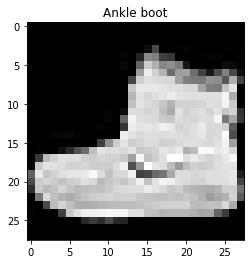

In [5]:
plt.imshow(x_train[0, :, :, 0], cmap='gray')
plt.title(label_dict[labels_train[0]])

### Make a Keras layer for adding noise
Learning a matrix of noise to add to an image isn't supported by default in Keras, so we'll define a custom layer that does that.

In [6]:
from tensorflow.keras.layers import Layer
'''
In the past, we would've used the following import statement to use the TensorFlow backend:

from keras import backend as K
'''


class AdversarialNoise(Layer):
    # Called when making a new layer of this kind
    def build(self, input_shape):
        # Add a variable to this model which has shape (28, 28, 1), is
        # initialized to zeros, and is constrained to have norm less than 0.1
        self.noise = self.add_weight(
            name='noise', shape=input_shape[1:], initializer='zero',
            constraint=keras.constraints.MaxNorm(0.1))
        
        super(AdversarialNoise, self).build(input_shape)

    # Called when input is passed through the layer
    def call(self, x):
        # The image the model will see is a pixel-wise sum 
        # of the input and the noise
        '''
        In the past, we would've used the following statement to access the backend:
        
        return K.bias_add(x, self.noise)
        '''
        return tf.add(x, self.noise)
    
    def compute_output_shape(self, input_shape):
        return input_shape

### Make tensors for the input image and the noise

In [7]:
from tensorflow.keras.layers import Input, Add, Lambda

# Creates a tensor that will hold the model input
input_image = Input(img_shape, name='input_image')

# This is what the model will see
noised_image = AdversarialNoise(name='noised_image')(input_image)

### Add hidden layers to the model

In [8]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten

# Again, when I call a layer like Conv2D(...) what's returned
# is a function that I then apply to a tensor.
layer = Conv2D(16, 3, strides=2, 
               padding='same', activation='relu')(noised_image)
layer = Conv2D(32, 3, padding='same', activation='relu')(layer)
layer = MaxPool2D()(layer)
layer = Conv2D(64, 3, padding='same', activation='relu')(layer)
layer = Conv2D(64, 3, padding='same', activation='relu')(layer)
layer = MaxPool2D()(layer)

layer = Flatten()(layer)
layer = Dense(128, activation='relu')(layer)
output_probs = Dense(10, activation='softmax', 
                     name='output_probs')(layer)

### Build and compile model

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = Model(input_image, output_probs)
model.summary()

# Prevent the model from changing the adversarial noise from zero
model.get_layer('noised_image').trainable = False

optimizer = Adam(lr=1e-3)
model.compile(optimizer, loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
noised_image (AdversarialNoi (None, 28, 28, 1)         784       
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928 

### Train model on fashion MNIST
Before we generate the adversarial example, we need to train the model.
So, we hold the noise at 0 and train the model as normal.

In [10]:
model.fit(x_train, y_train, batch_size=64, epochs=10,
          validation_data=(x_test, y_test))

Epoch 1/10
938/938 [==============================] - 28s 30ms/step - loss: 0.5138 - accuracy: 0.8127 - val_loss: 0.4147 - val_accuracy: 0.8428
Epoch 2/10
938/938 [==============================] - 29s 31ms/step - loss: 0.3230 - accuracy: 0.8821 - val_loss: 0.3036 - val_accuracy: 0.8886
Epoch 3/10
938/938 [==============================] - 30s 32ms/step - loss: 0.2744 - accuracy: 0.8995 - val_loss: 0.2921 - val_accuracy: 0.8949
Epoch 4/10
938/938 [==============================] - 30s 32ms/step - loss: 0.2425 - accuracy: 0.9103 - val_loss: 0.2652 - val_accuracy: 0.9054
Epoch 5/10
938/938 [==============================] - 30s 32ms/step - loss: 0.2196 - accuracy: 0.9196 - val_loss: 0.2599 - val_accuracy: 0.9064
Epoch 6/10
938/938 [==============================] - 30s 32ms/step - loss: 0.1999 - accuracy: 0.9260 - val_loss: 0.2581 - val_accuracy: 0.9079
Epoch 7/10
938/938 [==============================] - 30s 32ms/step - loss: 0.1802 - accuracy: 0.9329 - val_loss: 0.2654 - val_accuracy:

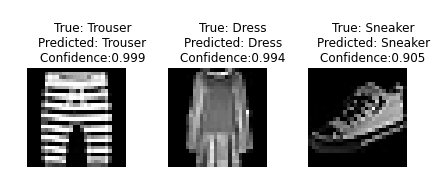

In [11]:
# Plot some predictions now that the model's trained
_, plots = plt.subplots(ncols=3)
plt.tight_layout()

for i in range(3):
    idx = np.random.randint(x_test.shape[0])
    
    probs = model.predict(np.array([x_test[idx]]))[0]
    pred = label_dict[np.argmax(probs)]
    confidence = np.max(probs)
    
    plots[i].imshow(x_test[idx, :, :, 0], cmap='gray')
    plots[i].axis('off')
    plots[i].set_title(
        '''
        True: {0}
        Predicted: {1}
        Confidence:{2:0.3f}'''.format(label_dict[labels_test[idx]], 
                                      pred, confidence))

### Prepare the model for training an adversarial example
Now, we'll freeze every layer except the noise and train to _maximize_ the loss.

In [12]:
from tensorflow.keras.losses import categorical_crossentropy

# Create a custom loss function that's just the negative of
# the default loss.
def adversarial_loss(y_true, y_pred):
    return -1 * categorical_crossentropy(y_true, y_pred)

# Prevent the model from changing any of its parameters
for layer in model.layers:
    layer.trainable = False
    
# Train the noise
model.get_layer('noised_image').trainable = True

# Re-compile the model to use adversarial loss
model.compile(optimizer, loss=adversarial_loss)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
noised_image (AdversarialNoi (None, 28, 28, 1)         784       
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928 

### Train the adversarial example

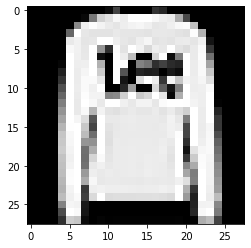

In [13]:
# Pick the image to turn into an adversarial example
x_adversarial = x_test[1]
y_adversarial = y_test[1]
plt.imshow(x_adversarial[:, :, 0], cmap='gray')

# This will be a "dataset" of 1 image
x_adversarial = np.expand_dims(x_adversarial, axis=0)
y_adversarial = np.expand_dims(y_adversarial, axis=0)

# Train the model to minimize the adversarial loss
for _ in range(100):
    model.train_on_batch(x_adversarial, y_adversarial)

### Extract and plot the adversarial noise
The adversarial noise is stored as weights in the model now.
We need to pull it out of the model as an image.

(-0.5, 27.5, 27.5, -0.5)

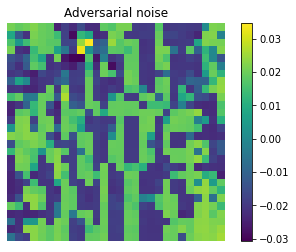

In [14]:
# Extract the noise from the layer weights
noise_layer = model.get_layer('noised_image')
adversarial_noise = noise_layer.get_weights()[0]

# Set the layer's weights to zero
noise_layer.set_weights([np.zeros_like(adversarial_noise)])

plt.imshow(adversarial_noise[:, :, 0])
plt.title('Adversarial noise')
plt.colorbar()
plt.axis('off')

### Use the adversarial noise
Finally, it's time to use the adversarial example.
It makes the network fail dramatically:

Text(0.5, 1.0, '\n    Image with adversarial noise\n    True: Pullover\n    Predicted: Coat\n    Confidence:0.973')

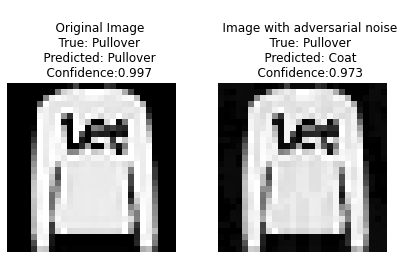

In [15]:
_, plots = plt.subplots(ncols=2)
plt.tight_layout()

img = np.array([x_test[1]])
lbl = label_dict[labels_test[1]]

# Plot the model's predictions on the original image
probs = model.predict(img)[0]
pred = label_dict[np.argmax(probs)]
confidence = np.max(probs)
 
plots[0].imshow(img[0, :, :, 0], cmap='gray')
plots[0].axis('off')
plots[0].set_title(
    '''
    Original Image
    True: {0}
    Predicted: {1}
    Confidence:{2:0.3f}'''.format(lbl, pred, confidence))

# Plot the model's predictions on the noised image
img_noised = img + adversarial_noise
probs = model.predict(img_noised)[0]
pred = label_dict[np.argmax(probs)]
confidence = np.max(probs)
 
plots[1].imshow(img_noised[0, :, :, 0], cmap='gray')
plots[1].axis('off')
plots[1].set_title(
    '''
    Image with adversarial noise
    True: {0}
    Predicted: {1}
    Confidence:{2:0.3f}'''.format(lbl, pred, confidence))